# Titanic Survival Analysis - Women and children first?

## Machine Learning - Classification using Decision Trees

The objective of this project is to explore the Titanic survival dataset by use of decision trees. 

Dataset used -  `titanic3.csv` (Source: [Link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt)).

Following analysis is carried out in this project - 

1. Analyzing the data using pandas library.
    * Creation of a column that specifies whether the person is a child (age <= 10)
    * Grouping of data by `sex`, `child`, `pclass` and interpret the survival rate.
2. Development of a decision tree with depth of 1.
    * Preprocessing the `sex` column using LabelEncoder
    * Developing the decision tree
    * Visually reproducing the decision tree using a seaborn barchart.
    * Use of the t-test from scipy.stats for statistically reproducing the decision.
    * Interpretation of the decision tree.
3. Development a decision tree with depth of 2.
    * Developing the decision tree.
    * Visually reproducing the decision tree using seaborn barcharts.
    * Use of the ranksums test from scipy.stats for statistically reproducing the decisions.
    * Interpretation of the decision tree. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.metrics as sm
import sklearn.preprocessing as pp
from sklearn.tree import DecisionTreeClassifier

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
tc = pd.read_csv("titanic3.csv")

In [6]:
tc.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

## Description of the dataset

Each row is a passenger on the Titanic. The columns report attributes for the passengers:

| Column | Description | Relevant for this project|
|--------|-------------|--------|
|`survived`|1 = survived, 0 = died | **X**|
|`pclass`| 1 = first class, 2 = second class, 3 = third class |**X**|
|`name`| Name of the passenger| |
|`sex`| male or female|**X**|
|`age`| age in years|**X**|
|`sibsp`| The number of siblings or spouses that are also traveling on the Titanic| |
|`parch`| The number of parents or childen that are also traveling on the Titanic| |
|`ticket`|The ticket number| |
|`fare`| The ticket price | |
|`cabin`| The cabin number | |
|`embarked`| The starting city | |
|`boat`| The emergency boat number | |
|`body`| The identification number of the body | |
|`home.dest`| The destination of the passenger | |

## Women and children first?

### Creating a column that specifies whether the person is a child (10 years or younger)


In [7]:
#child column is created
tc['child']=[1 if x<=10 else 0 for x in tc['age']]
tc.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,child
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0


### Group the data by `sex`, `child`, `pclass` and interpret the survival rate.

Survival rate is calculated by dividing the sum of the total survived people by the count of people in subclassses of sex, pclass and child column

In [8]:
#rate is the column created which depicts the survival rate
Survival=pd.DataFrame(tc.groupby(['sex','child','pclass'])['survived'].agg(['sum','count']))
Survival['rate']=Survival['sum']/Survival['count']
Survival

sum  count      rate
sex    child pclass                        
female 0     1.0     139.0    143  0.972028
             2.0      83.0     95  0.873684
             3.0      92.0    187  0.491979
       1     1.0       0.0      1  0.000000
             2.0      11.0     11  1.000000
             3.0      14.0     29  0.482759
male   0     1.0      58.0    176  0.329545
             2.0      14.0    160  0.087500
             3.0      64.0    462  0.138528
       1     1.0       3.0      3  1.000000
             2.0      11.0     11  1.000000
             3.0      11.0     31  0.354839

## Decision Tree with depth of 1

### Restricting the analysis on the relevant columns (as per data describing table)

In [9]:
tc=tc.copy()
tc.drop(['name','sibsp','parch','fare','ticket','cabin','embarked','boat','body','home.dest'],axis=1, inplace=True)
tc.head()

,pclass,survived,sex,age,child
0,1.0,1.0,female,29.0000,0
1,1.0,1.0,male,0.9167,1
2,1.0,0.0,female,2.0000,1
3,1.0,0.0,male,30.0000,0
4,1.0,0.0,female,25.0000,0


### Preprocessing the `sex` column using LabelEncoder

`sex` column has two values - Male, Female. Preprocessing is used to attribute numeric values to the column data. The data in the column will be utilized as a feature and therefore it is required to be preprocessed.

In [10]:
le = pp.LabelEncoder()
tc['sex'].unique()
tc.sex=le.fit_transform(tc['sex'].astype(str))

array(['female', 'male', nan], dtype=object)

In [11]:
#np.unique(y)
tc['sex'].unique()

array([0, 1, 2], dtype=int64)

Now the `sex` column has numeric values of 0, 1, 2 instead of Male, Female, NaN

### Cleaning the dataset

In [12]:
tc=tc.dropna()

### Building of the decision tree

This step involves **building** and **visualizing** a decision tree with depth of 1 (i.e., one root and two leaf nodes) to find differences between passengers who survived and those who did not. 

In [13]:
X=tc.drop(['survived'],axis=1)
y=tc['survived']

In [14]:
#Setting the depth of the decision tree as 1
dtc_tc_survival=DecisionTreeClassifier(max_depth=1).fit(X,y)

Using following line code for visualization and use of graphviz library

In [15]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/ajayk/AppData/Local/Programs/Python/Python36-32/Lib/site-packages/graphviz-2.38/release/bin/'

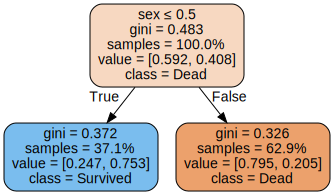

In [16]:
import graphviz
dot_data = tree.export_graphviz(dtc_tc_survival, out_file=None,
                         feature_names=list(X.columns),
                         class_names = ['Survived' if i == 1 else 'Dead' for i in dtc_tc_survival.classes_],
                         filled=True, rounded=True, special_characters=True, proportion=True,
                        )
graph = graphviz.Source(dot_data)
graph 

In [17]:
tc.groupby('sex')['survived'].agg(['sum','count'])

,sum,count
sex,,
0,292.0,388
1,135.0,658


### Interpretation of Decision Tree

It can be interpreted from this tree that it is taking the complete 100% dataset and it says that 59.2% Died and 40.8% survived. Thus, the probability of dying is more, as it is telling about the root node. Also, this is why the class is classified as Dead.

Data is further divided on based of sex. If female then True or else false. So now the updated sample has 37.1%(female) and 62.9%(male) samples, as shown in the leaf nodes.

The left side of the tree depicts passenger which are female. Also it tells 24.7% people died and 75.3% survived. Thus, in this group, chances of survival is high and hence the class is classified as Survived.

The right side of the tree shows passenger which are male. Also it tells 79.5% male died and 20.5% survived among males. Thus, in this group, chances of survival is less and hence the class is classified as Dead.

### Visually reproducing the decision tree using a seaborn factorplot.

To visualize the factorplot of the decision tree a dataframe having survival rate is created

In [18]:
tc_t=pd.DataFrame(tc.groupby(['sex','survived'])['survived'].agg(['count'])/tc.groupby(['sex'])['survived'].agg(['count'])).reset_index()
tc_t

,sex,survived,count
0,0,0.0,0.247423
1,0,1.0,0.752577
2,1,0.0,0.794833
3,1,1.0,0.205167


### Plotting Factorplot of the decision tree

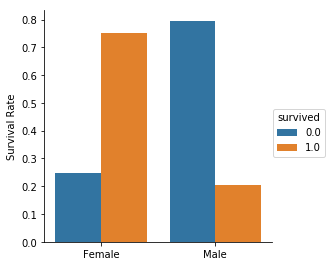

In [19]:
g=sns.factorplot(x="sex", y="count",data=tc_t, hue="survived", kind='bar'); 
g.set_axis_labels("", "Survival Rate").set_xticklabels(["Female", "Male"]);

Based on the above graph, it can be seen that female passengers had greater survival rate.

### Using the t-test from `scipy.stats` to statistically reproduce the decision.

**t-test** is a standard method of producing statistical value and generating the pvalue. 
The lesser the pvalue the better. If there is a difference between these values showsdifference between the 2 datasets or not

If the p-value is larger than 0.05, we cannot conclude that a significant difference exists.

In [20]:
from scipy.stats import ttest_ind
from scipy.stats import stats

In [21]:
ttest_ind(tc[tc['sex']==0]['survived'], tc[tc['sex']==1]['survived'])

Ttest_indResult(statistic=20.622130510238705, pvalue=1.566605331038222e-79)

The pvalue is small, and shows that there is a significant difference between the two passed datasets

## Decision tree with depth of 2

This step involves **building** and **visualizing** a decision tree with depth of 2 (i.e. four leaves) to find differences between passengers who survived and those who did not. 

In [22]:
#Setting depth as 2
dtc_tc_survival=DecisionTreeClassifier(max_depth=2).fit(X,y)

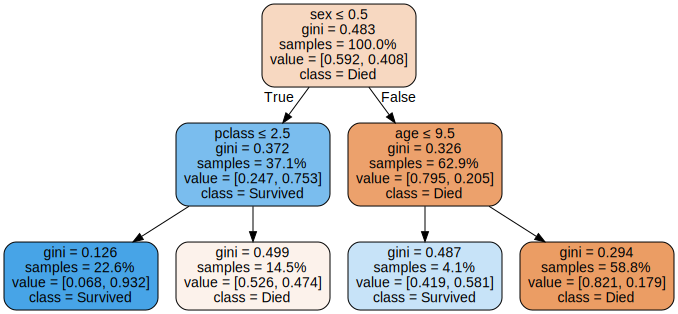

In [23]:
import graphviz
dot_data = tree.export_graphviz(dtc_tc_survival, out_file=None,
                         feature_names=list(X.columns),
                         class_names =['Survived' if i == 1 else 'Died' for i in dtc_tc_survival.classes_],
                         filled=True,rounded=True, special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

### Interpretation of Decision Tree

It can be interpreted from this tree that it is taking the complete 100% dataset and it comes out that 59.2% Died and 40.8% survived. Thus, the probability of dying is more and shown in root node. Hence the class is classified as Died.

Data is further divided based on sex. If female then True or else false. So, now the sample of 37.1%(female) and 62.9%(male) sample, as shown in the 1 level of the tree.

The left side of the tree shows passenger which are female. Also it tells 24.7% people died and 75.3% survived. Thus, in this group, chances of survival is high and hence the class is classified as Survived.

It further divide the data based on passenger class. If class is less than 2.5( basically class 1 and 2) then True and it falls in the left most side(22.6% sample) and if the class is more than 2.5 then this leaf node will fall at the right side(14.5% sample) of this node.

So now if the group is female and pclass is 1 or 2 then chances of survival is more and thus the class is classified as Survived. However if the class is 3, chances of survival is less and thus the class is classified as Died.

The right side of the tree shows passenger which are Male. Also it tells 79.5% male died and 20.5% survived among males. Thus, in this group, chances of survival is less and hence the class is classified as Died.

It further divide the data based on age. If age is less than 9.5( basically child) then True and it falls in the left side(4.1% sample) telling that chances of survival is more.

However, if the age is more than 9.5 then this leaf node(58.8% sample) will fall at the right most side of this node. This shows the chances of survival of passengers in this group is less and thus its classified as Died.

To conclude, **Women and children have more survival rate as compared to Men.**

###  Visually reproducing the left side of the decision tree using seaborn barcharts

In [24]:
tc_female=pd.DataFrame(tc[tc['sex']==0].groupby(['survived','pclass'])['survived'].agg(['count'])).reset_index()
tc_female;

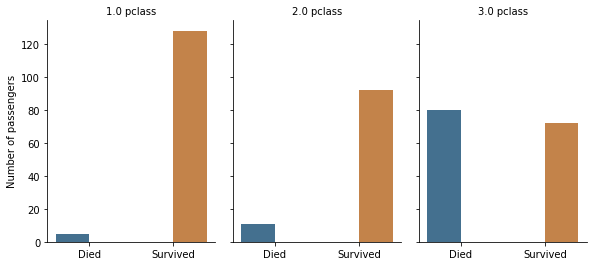

In [25]:
g=sns.factorplot(x="survived", y="count",data=tc_female, hue='survived', col='pclass', saturation=.5,kind="bar",ci=None, aspect=.7, legend=False);
(g.set_axis_labels("", "Number of passengers")
   .set_xticklabels(["Died", "Survived"])
   .set_titles("{col_name} {col_var}")
);

Number of Females passengers of class 1 had maximum survival than of class 3 female passengers.

### Use of the ranksums test from scipy.stats to statistically reproduce the decision on the left side.


Ranksums is the robust method for identifying the significant difference and calculating the statistical value. It is used when there are more groups to compare.

In [26]:
from scipy.stats import f_oneway, ranksums

In [27]:
tc_f=tc[tc['sex']==0]
ranksums(tc_f[tc_f['pclass']<=2.5 ]['survived'],tc_f[tc_f['pclass']>2.5]['survived'])

RanksumsResult(statistic=7.62642719309532, pvalue=2.4134913208883318e-14)

Here as well, pvalue is small and thus significant difference exists.

###  Visually reproducing the right side of the decision tree using seaborn barcharts

There are several unique values for age field. Therefore, to plot them it is required that bins of 10 are created and then the data is stored in it using a new column- `dist_age`

In [28]:
tc['dist_age']=pd.cut(tc.age, 10)
tc['dist_age'].unique()

[(24.117, 32.1], (0.0869, 8.15], (40.083, 48.067], (56.05, 64.033], (32.1, 40.083], (48.067, 56.05], (64.033, 72.017], (16.133, 24.117], (72.017, 80.0], (8.15, 16.133]]
Categories (10, interval[float64]): [(0.0869, 8.15] < (8.15, 16.133] < (16.133, 24.117] < (24.117, 32.1] ... (48.067, 56.05] < (56.05, 64.033] < (64.033, 72.017] < (72.017, 80.0]]

#### Creating the dataframe for only male passengers as they represet the right side of the tree¶

In [29]:
tc_male=pd.DataFrame(tc[tc['sex']==1].groupby(['survived','dist_age'])['survived'].agg(['count'])).reset_index()
tc_male;

### Plotting the factor plot for the right side of the tree¶

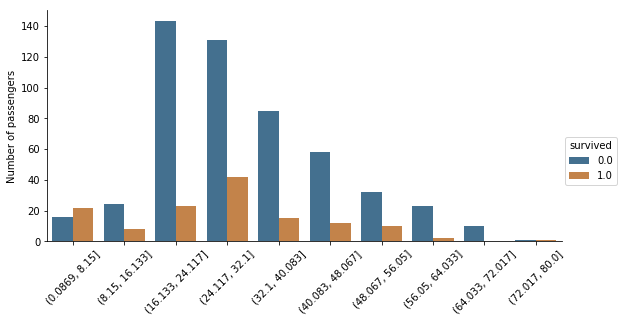

In [30]:
g=sns.factorplot(x="dist_age", y="count",data=tc_male, hue='survived', saturation=.5,kind="bar", ci=None, aspect=2);
axes = g.axes.flatten();
g.set_axis_labels("", "Number of passengers");
plt.xticks(rotation=45);

Based on this, it can be see that only for children the number of passengers survived were more than not survive. For rest of the age group, people falling in the right most side of the tree, have less chances of survival.

### Use of ranksums test from scipy.stats to statistically reproduce the decisions on the right side.

In [31]:
tc_m=tc[tc['sex']==1]
ranksums(tc_m[tc_m['age']<=9.5]['survived'],tc_m[tc_m['age']>9.5]['survived'])

RanksumsResult(statistic=4.4166379535516365, pvalue=1.0024793022808227e-05)

As the pvalue is very small it can be said that there is significant difference between the passed datasets

## References

Following are the reference links:

https://seaborn.pydata.org/generated/seaborn.factorplot.html <br>
https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.ranksums.html <br>
https://seaborn.pydata.org/tutorial/categorical.html <br>
http://blog.minitab.com/blog/understanding-statistics/what-can-you-say-when-your-p-value-is-greater-than-005